# <a>Content</a>

1. <a href="#1">Introduction</a>
2. <a href="#2">Photo OCR</a>
3. <a href="#3">Text detection</a>
4. <a href="#4">Load the data and dependencies</a>
5. <a href="#5">Train the model</a>
6. <a href="#6">Detect numbers in larger images</a>
7. <a href="#7">Conclusion</a>

# Introduction
In this kernel we will be getting our hands on a very famous computer vision problem, called photo OCR. More specifically the characters detection part of the problem, although i will be releasing in future kernels the rest of the other parts of the project (just to not make this kernel very crowded). <br>
We will be using pytorch, and relying on andrew's ng <a href="https://www.coursera.org/learn/machine-learning">course</a> method to frame the problem.

# Photo OCR
Photo OCR as defined by wikipedia: "Optical character recognition or optical character reader, often abbreviated as OCR, is the mechanical or electronic conversion of images of typed, handwritten or printed text into machine-encoded text, whether from a scanned document, a photo of a document, a scene-photo (for example the text on signs and billboards in a landscape photo) or from subtitle text superimposed on an image (for example from a television broadcast)" <a href="https://en.wikipedia.org/wiki/Optical_character_recognition">[source]</a> <br>
In andrew's ng <a href="https://www.coursera.org/learn/machine-learning">course</a>, i found a great pipeline definition of the problem, which we will be using as a guideline through subsequent kernels. <img src="https://raw.githubusercontent.com/ritchieng/machine-learning-stanford/master/w11_application_example_ocr/photoocr.png" alt="Photo OCR Pipeline" />

# Text detection
This part of the problem consits of creating bouding boxes around the detected text of the image. There are many techniques to do it, like sliding windows. But in this kernel we are going to use a more efficient way, allowing us to bound the text in boxes in a single pass, thus reducing the computation. The technique is called Convolutional fast sliding windows.<br>
Following this, we should expand the boxes close to each other in orther to detect words and phrases, so the end result should look something like this. <img src="https://raw.githubusercontent.com/ritchieng/machine-learning-stanford/master/w11_application_example_ocr/photoocr4.png" alt="end result" />

# Load the data and dependencies
We will be using mnsit, and try to detect numbers in different parts of an image.

In [1]:
# Dependencies
import torch
from torch import optim
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [2]:
# test cuda if available to speed training with gpu power
use_cuda  = torch.cuda.is_available()

In [3]:
# transform image to pytorch tensor
"""it should be a great idea to do data augmentation in order to detect
    numbers in different positions and orientations, but we can just skip that now for the demo"""

transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 22097362.61it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 443172.76it/s]
  1%|          | 16384/1648877 [00:00<00:11, 145150.82it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 6062422.23it/s]                           
8192it [00:00, 66042.89it/s]            


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


# Train the Model
Let's create first a classifier using convolution layers, the output will be of shape (1, 1, 10) for a single image in order to classify from the 10 different classes.<br>
Larger images would have larger output shape, but this will be used to find parts of it that were responsible for the largest activation, which also means the bounding boxes will be of (28,28) shape, the same as the numbers images.<br>
Note :  We will talk about a technique to use in order to use other bounding box sizes.

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.conv3 = nn.Conv2d(32, 800, 5)
        self.conv4 = nn.Conv2d(800, 800, 1)
        self.conv5 = nn.Conv2d(800, 10, 1)
        self.pool = nn.MaxPool2d((2,2))
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        
        return x
        
        

In [5]:
model = Model()
if use_cuda:
    model = model.cuda()

In [6]:
def train_model(model, train_loader, test_loader, n_epochs):
    """helper function to train the model
        inputs: model --> our model
                train_loader --> the train images loader
                test_loader --> the test images loader
                n_epchs --> number of iterations                
    """
    # specify loss function (categorical cross-entropy)
    criterion = nn.CrossEntropyLoss()
    # specify optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    min_test_accuracy = 0
    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0
        train_accuracy = 0
        test_accuracy = 0
        ###################
        # train the model #
        ###################
        model.train()
        for images, labels in train_loader:
            # move tensors to GPU if CUDA is available
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(images).squeeze()
            _, outs_k = logits.topk(1, dim=1)
            equals = (outs_k == labels.view(*outs_k.shape))
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # calculate the batch loss
            loss = criterion(logits, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()


        train_loss = train_loss/len(train_loader)
        train_accuracy /= len(train_loader)
        ######################
        # validate the model #
        ######################
        model.eval()
        for images, labels in test_loader:
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()
            logits = model(images).squeeze()
            _, outs_k = logits.topk(1, dim=1)
            equals = (outs_k == labels.view(*outs_k.shape))
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        test_accuracy /= len(test_loader)
        print("""Epoch: {} \tTraining Loss: {:.6f} 
        \tTrain accuracy: {:.6f} \Test accuracy: {:.6f}""".format(
            epoch, train_loss,  train_accuracy, test_accuracy))
    
        # save model if validation accuracy has increased
        if test_accuracy >= min_test_accuracy:    
            torch.save(model.state_dict(), 'model.pt')
            min_test_accuracy = test_accuracy

In [7]:
train_model(model, train_loader, test_loader, 5)

Epoch: 1 	Training Loss: 0.123511 
        	Train accuracy: 0.962683 \Test accuracy: 0.982700
Epoch: 2 	Training Loss: 0.050485 
        	Train accuracy: 0.985567 \Test accuracy: 0.987000
Epoch: 3 	Training Loss: 0.036467 
        	Train accuracy: 0.989750 \Test accuracy: 0.987900
Epoch: 4 	Training Loss: 0.029584 
        	Train accuracy: 0.991350 \Test accuracy: 0.992000
Epoch: 5 	Training Loss: 0.025206 
        	Train accuracy: 0.993083 \Test accuracy: 0.992300


Let's see the results giving by the model

In [8]:
model.eval()

Model(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 800, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(800, 800, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(800, 10, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)

Text(0.5, 1.0, '7(1.00)')

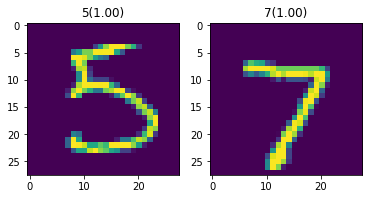

In [9]:
# load first batch
test_iterator = iter(test_loader)
images, labels = test_iterator.next()
# send it to gpu if available
if use_cuda:
    images = images.cuda()
    labels = labels.cuda()
# get predictions
predictions = F.softmax(model(images), dim=1).squeeze()
probs , outs = predictions.topk(1, dim=1)

# get random images from bacth
random_idx = np.random.randint(batch_size)
if use_cuda:
    image1 = images[random_idx].cpu().detach().numpy().squeeze()
    image2 = images[(random_idx+1)%batch_size].cpu().detach().numpy().squeeze()
else : 
    image1 = images[random_idx].numpy().squeeze()
    image2 = images[(random_idx+1)%batch_size].numpy().squeeze()    

prob1 = probs[random_idx, 0]. item()
out1 = outs[random_idx, 0]. item()
prob2 = probs[(random_idx+1)%batch_size, 0]. item()
out2 = outs[(random_idx+1)%batch_size, 0]. item()

# visualise results
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image1)
axs[0].set_title('{}({:.2f})'.format(out1,prob1))
axs[1].imshow(image2)
axs[1].set_title('{}({:.2f})'.format(out2,prob2))



# Detect numbers in larger images

Let's create a bigger image with random numbers

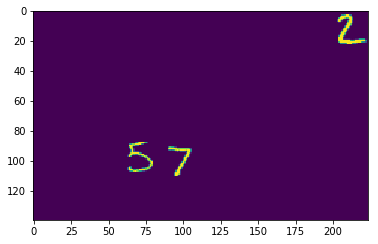

In [10]:
first_tensor = images[random_idx]
second_tensor = images[(random_idx+1)%batch_size]
third_tensor = images[(random_idx+2)%batch_size]

black_tensor = torch.zeros_like(first_tensor)

tmp_0 = torch.cat((black_tensor, black_tensor, black_tensor, black_tensor,
                   black_tensor, black_tensor, black_tensor, third_tensor), 2)
tmp_1 = torch.cat((black_tensor, black_tensor, black_tensor, black_tensor,
                   black_tensor, black_tensor, black_tensor, black_tensor), 2)
tmp_2 = torch.cat((black_tensor, black_tensor, black_tensor, black_tensor,
                   black_tensor, black_tensor, black_tensor, black_tensor), 2)

tmp_3 = torch.cat((black_tensor, black_tensor,first_tensor, second_tensor,
                   black_tensor, black_tensor, black_tensor, black_tensor), 2)
tmp_4 = torch.cat((black_tensor, black_tensor, black_tensor, black_tensor,
                   black_tensor, black_tensor, black_tensor, black_tensor), 2)

test_image = torch.cat((tmp_0, tmp_1, tmp_2, tmp_3, tmp_4), 1)

if use_cuda:
    test_image_numpy = test_image.cpu().numpy().squeeze()
else : 
    test_image_numpy = test_image.numpy().squeeze()
    
plt.imshow(test_image_numpy)

In [11]:
# get predicted labels and score
prediction = F.softmax(model(test_image.unsqueeze(dim=0)))
values, indices = prediction.squeeze().max(0)
# get the shape
values.shape, indices.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


(torch.Size([29, 50]), torch.Size([29, 50]))

As you can see the output is no longer 1d array, but this is where the trick comes handy each cell in the output corresponds to a 28x28 frame in the original image. So we can see which parts of the original image activate the most (with a certain confidence level).

In [12]:
if use_cuda:
    # score
    values = values.cpu().detach().numpy()
    # labels
    indices = indices.cpu().detach().numpy()
else :
    values = values.numpy()
    indices = indices.numpy()
    

In [13]:
# let's define our confidence level
CONFIDENCE_LEVEL = 0.99 

let's  see the parts which activated the most in to output.<br>
We will be matching these outputs to a 28x28 frame in the input image shortly.

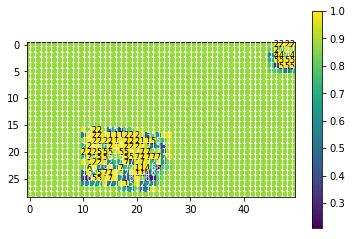

In [14]:
plt.imshow(values)
plt.colorbar()
height, width = indices.shape
for y in range(height):
        for x in range(width):
            val = indices[y, x]
            plt.annotate(str(val), xy=(x,y),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if values[y][x]<CONFIDENCE_LEVEL else 'black')

Now let's write a function that maps each output cell to a 28x28 frame in the input, let's define each frame with (y, x, y_witdth, x_width)<br>
The first cell in the (29, 50) output which is (0, 0) corresponds to (0, 0, 28, 28) box in the input. The second cell (0, 1) corresponds to (0, 4, 28, 28) box, in other words the step is 4.


In [15]:
def extract_boxes(image, step, sub_size_x=28, sub_size_y=28):
    height, width = image.shape[0], image.shape[1]
    nb_slides_x = (width-sub_size_x)//step + 1
    nb_slides_y = (height-sub_size_y)//step + 1
    location_boxes = []
    for y in range(nb_slides_y):
        for x in range(nb_slides_x):
            location_boxes.append([y*step, x*step, sub_size_y, sub_size_x])
    return np.array(location_boxes)

In [16]:
location_boxes = extract_boxes(test_image_numpy, step=4)

In [17]:
len(location_boxes)

1450

In [18]:
len(values.flatten())

1450

As you can see the number of bounding boxes corresponds to the number of cells in the output.

In [19]:
# keep cells which activates more than the confidence level
indexes_to_keep = np.where(values.flatten() > CONFIDENCE_LEVEL)[0]
# These are the confidences and bounding boxes we want to keep for the detection
confident_scores = values.flatten()[indexes_to_keep]
confident_boxes = location_boxes[indexes_to_keep]
confident_labels = indices.flatten()[indexes_to_keep]

In [20]:
def draw_predictions(image, confident_boxes):
    for y, x, box_size_y, box_size_x in confident_boxes:
        image = cv2.rectangle(image,(x,y),(x+box_size_x,y+box_size_y),(255,0,0),1)
    return image

Let's draw the most confident boxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


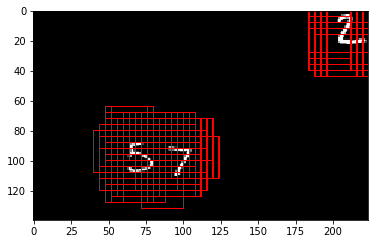

In [21]:
test_image_with_boxes = cv2.cvtColor(test_image_numpy.copy(), cv2.COLOR_GRAY2BGR)
test_image_with_boxes = draw_predictions(test_image_with_boxes, confident_boxes)
plt.imshow(test_image_with_boxes);


It's time to write the expansion function, which joins boxes close to each other with a certain slide defined

In [22]:
def expansion(bounding_boxes, slide_x = 1, slide_y=1):
    nb_boxes = len(bounding_boxes)   
    idx = 0
    while idx < nb_boxes-1:
        y1, x1, box_size_y1, box_size_x1 = bounding_boxes[idx]
        y2, x2, box_size_y2, box_size_x2 = bounding_boxes[idx+1]      
        if (((x1 + box_size_x1 + slide_x >= x2) or (x2 + box_size_x2 + slide_x >= x1))
            and (y1 + box_size_y1 + slide_y >= y2)):
            x = min(x1, x2)
            y = min(y1, y2)
            box_size_y = max(y2+box_size_y2, y1+box_size_y1) - min(y1,y2)
            box_size_x = max(x2+box_size_x2, x1+box_size_x1) - min(x1,x2)
            bounding_boxes[idx]= np.array([y, x, box_size_y, box_size_x])
            bounding_boxes = np.delete(bounding_boxes, idx+1, axis = 0 )
            nb_boxes = len(bounding_boxes)   
        else:
            idx+=1

    return bounding_boxes
        

In [23]:
bounding_boxes = expansion(confident_boxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


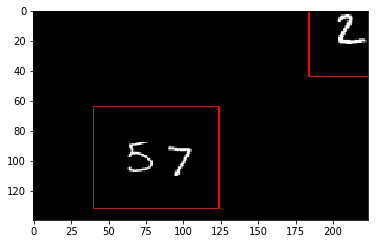

In [24]:
test_image_with_boxes = cv2.cvtColor(test_image_numpy.copy(), cv2.COLOR_GRAY2BGR)
test_image_with_boxes = draw_predictions(test_image_with_boxes, bounding_boxes)
plt.imshow(test_image_with_boxes);

# Conclusion

So we've succesfully detected the numbers, but as we saw, we only used 28x28 frames to detect numbers, what if it they were bigger or very small. One solution is instead of changing the size of the frames, we can resize the input image, to make the frames bigger or smaller. We are not going to tackle this problem in this kernel (it's already complicated as it is), but you can shoot me a message and i'll be glad to help.<br>
Next step is the text  segmentation, i will be releasing a kernel shortly after this one about it with the link to it in this kernel.<br>
This is my first public kernel, so please let me know if you have some remarks or found some mistakes.<br>
Thank you for sticking around.